In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
results = pd.read_csv('results/final_results_20251121_040926.csv')
results_filtered = results[(results['TempoTotal'] >= 1800) & (results['EstrategiaBusca'] == 'first')]
results_filtered.head()

,Instancia,Dimensao,Experimento,Heuristica,EstrategiaBusca,Intensificacao,Diversificacao,CustoInicial,CustoFinal,MelhoriaPercentual,TempoTotal,Iteracoes,DescricaoCenario
6,X-n101-k25,101,Req4_Base_first,savings,first,False,False,28941.984425,28819.919974,0.421756,1800.029741,12895,Sem Int / Sem Div (first)
7,X-n101-k25,101,Req4_Int_first,savings,first,True,False,28941.984425,28819.919974,0.421756,1800.044069,12860,Só Intensificação (first)
8,X-n101-k25,101,Req4_Div_first,savings,first,False,True,28941.984425,28221.663975,2.488843,1800.008291,46434,Só Diversificação (ILS) (first)
9,X-n101-k25,101,Req4_Full_first,savings,first,True,True,28941.984425,28226.093869,2.473537,1800.014917,28047,Completo (ILS + Int) (first)
20,X-n204-k19,204,Req4_Base_first,savings,first,False,False,21377.709027,21080.770036,1.389012,1800.104744,2017,Sem Int / Sem Div (first)


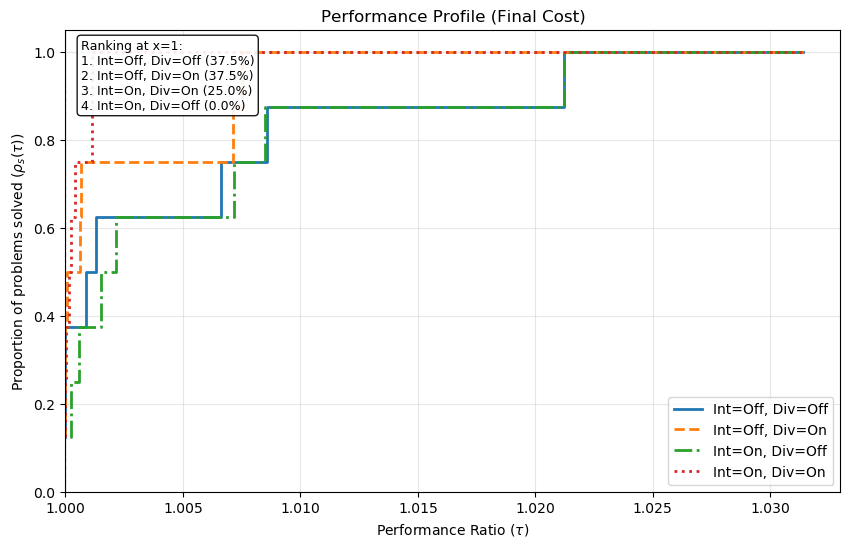

In [ ]:
# Prepare data for performance profile
# Create a readable configuration label
results_filtered = results_filtered.copy()
results_filtered['Config'] = results_filtered.apply(
    lambda x: f"Int={'Lig' if x['Intensificacao'] else 'Desl'}, Div={'Lig' if x['Diversificacao'] else 'Desl'}", 
    axis=1
)

# Pivot the dataframe to have instances as rows and configs as columns
pivot_df = results_filtered.pivot(index='Instancia', columns='Config', values='CustoFinal')

# Calculate performance ratios
# For each instance, divide the solver's cost by the minimum cost found for that instance
min_costs = pivot_df.min(axis=1)
ratios = pivot_df.divide(min_costs, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Store the value at x=1 for each config to determine ordering
values_at_1 = {}

# Define line styles for different configs
line_styles = ['-', '--', '-.', ':']

# For each configuration, calculate the CDF of the ratios
for idx, config in enumerate(ratios.columns):
    # Get ratios for this config and sort them
    config_ratios = np.sort(ratios[config])
    
    # Calculate the proportion of instances solved within each ratio
    # y-values range from 1/N to N/N
    y_values = np.arange(1, len(config_ratios) + 1) / len(config_ratios)
    
    # Extend the curve to the right by adding a final point
    # Find the maximum ratio across all configs to set a reasonable limit
    max_ratio = ratios.max().max()
    config_ratios_extended = np.append(config_ratios, max_ratio * 1.01)
    y_values_extended = np.append(y_values, 1.0)
    
    # Plot using step function with different line styles
    plt.step(config_ratios_extended, y_values_extended, label=config, 
             where='post', linestyle=line_styles[idx % len(line_styles)], linewidth=2)
    
    # Store the y-value at x=1 (proportion of instances where this config is within ratio 1.0)
    values_at_1[config] = np.sum(config_ratios <= 1.0) / len(config_ratios)

# Sort configs by their value at x=1 (descending order)
sorted_configs = sorted(values_at_1.items(), key=lambda x: x[1], reverse=True)

# Create text for the ranking box
ranking_text = "Ranking em x=1:\n" + "\n".join([f"{rank}. {config} ({val:.1%})" for rank, (config, val) in enumerate(sorted_configs, 1)])

# Add text box
plt.text(0.98, 0.25, ranking_text, transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Add a vertical line at x=1 for reference
plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel(r'Razão de Desempenho ($\tau$)')
plt.ylabel(r'Proporção de problemas resolvidos ($\rho_s(\tau)$)')
plt.title('Perfil de Desempenho (Custo Final)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(left=1.0)  # Start x-axis at 1.0
plt.ylim(0, 1.05)   # Give some space above 1.0
plt.show()